<a href="https://colab.research.google.com/github/fengtastics/111-Capstone/blob/master/Arterra_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3

#https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

#https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

In [141]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib

from fbprophet import Prophet

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [142]:
from numpy import log

In [143]:
#raw_df = pd.read_csv("C:\\Users\\mcinn\\Documents\\timeseries_vqa.csv")
raw_df = pd.read_csv(
   "timeseries_vqa.csv",      # relative python path to subdirectory
    usecols=[ "AWC Fiscal Year Month Abbr",	"Brand","Varietal Group", 
    "9L Cases","Avg Sales Price","Sales Dollars"],  # Only load the columns specified.
   )

raw_df.head()
#raw_df.info()

,AWC Fiscal Year Month Abbr,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,F2017 FEB,BLACK SAGE VINEYARD,CABERNET FRANC,17,$28.74,"5,912"
1,F2017 FEB,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1,$28.74,368
2,F2017 FEB,BLACK SAGE VINEYARD,MERLOT,11,$28.74,"3,698"
3,F2017 FEB,BLACK SAGE VINEYARD,OTHER,2,$29.89,909
4,F2017 FEB,CULMINA,CHARDONNAY,0,$41.50,85


In [144]:
# replace Sales Dollar , 9L Cases to NUMBERS format

raw_df['Sales Dollars'] = raw_df['Sales Dollars'].str.replace(',', '').astype(float)
raw_df['9L Cases'] = raw_df['9L Cases'].str.replace(',', '').astype(float)
raw_df['Avg Sales Price'] = raw_df['Avg Sales Price'].str.replace('$', '').astype(float)
raw_df.head()



,AWC Fiscal Year Month Abbr,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,F2017 FEB,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,F2017 FEB,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,F2017 FEB,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,F2017 FEB,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,F2017 FEB,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [145]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3671 entries, 0 to 3670
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AWC Fiscal Year Month Abbr  3671 non-null   object 
 1   Brand                       3671 non-null   object 
 2   Varietal Group              3671 non-null   object 
 3   9L Cases                    3671 non-null   float64
 4   Avg Sales Price             3217 non-null   float64
 5   Sales Dollars               3671 non-null   float64
dtypes: float64(3), object(3)
memory usage: 172.2+ KB


In [146]:
raw_df = raw_df.rename({'AWC Fiscal Year Month Abbr': 'Date'}, axis=1) 
raw_df['Date'] = raw_df['Date'].str[1:]
raw_df.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,2017 FEB,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,2017 FEB,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,2017 FEB,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,2017 FEB,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,2017 FEB,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [147]:
import datetime
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
0,2017-02-01,BLACK SAGE VINEYARD,CABERNET FRANC,17.0,28.74,5912.0
1,2017-02-01,BLACK SAGE VINEYARD,CABERNET SAUVIGNON,1.0,28.74,368.0
2,2017-02-01,BLACK SAGE VINEYARD,MERLOT,11.0,28.74,3698.0
3,2017-02-01,BLACK SAGE VINEYARD,OTHER,2.0,29.89,909.0
4,2017-02-01,CULMINA,CHARDONNAY,0.0,41.50,85.0


In [148]:
raw_df['Date'].min(), raw_df['Date'].max()

(Timestamp('2017-02-01 00:00:00'), Timestamp('2021-10-01 00:00:00'))

In [149]:
raw_df['Varietal Group'].unique()


array(['CABERNET FRANC', 'CABERNET SAUVIGNON', 'MERLOT', 'OTHER',
       'CHARDONNAY', 'RED BLEND', 'RIESLING', 'VIDAL', 'PINOT NOIR',
       'CHENIN BLANC', 'PINOT BLANC', 'PINOT GRIGIO', 'SHIRAZ',
       'ZINFANDEL', 'WHITE BLEND', 'SAUVIGNON BLANC', 'VIOGNIER', 'ROSE',
       'GEWURZTRAMINER', 'TEMPRANILLO', 'MALBEC', 'UNASSIGNED'],
      dtype=object)

In [150]:
cabernet_franc = raw_df.loc[raw_df['Varietal Group'] == 'CABERNET FRANC']
cabernet_sav = raw_df.loc[raw_df['Varietal Group'] == 'CABERNET SAUVIGNON']
merlot = raw_df.loc[raw_df['Varietal Group'] == 'MERLOT']
chardonnay = raw_df.loc[raw_df['Varietal Group'] == 'CHARDONNAY']
red_blend = raw_df.loc[raw_df['Varietal Group'] == 'RED BLEND']
riesling = raw_df.loc[raw_df['Varietal Group'] == 'RIESLING']
vidal = raw_df.loc[raw_df['Varietal Group'] == 'VIDAL']
pinot_noir = raw_df.loc[raw_df['Varietal Group'] == 'PINOT NOIR']
chenin_blanc = raw_df.loc[raw_df['Varietal Group'] == 'CHENIN BLANC']
pinot_blanc = raw_df.loc[raw_df['Varietal Group'] == 'PINOT BLANC']
pinot_grigio = raw_df.loc[raw_df['Varietal Group'] == 'PINOT GRIGIO']
shiraz = raw_df.loc[raw_df['Varietal Group'] == 'SHIRAZ']
zinfandel = raw_df.loc[raw_df['Varietal Group'] == 'ZINFANDEL']
white_blend = raw_df.loc[raw_df['Varietal Group'] == 'WHITE BLEND']
sav_blanc = raw_df.loc[raw_df['Varietal Group'] == 'SAUVIGNON BLANC']
viognier = raw_df.loc[raw_df['Varietal Group'] == 'VIOGNIER']
rose = raw_df.loc[raw_df['Varietal Group'] == 'ROSE']
gewurz = raw_df.loc[raw_df['Varietal Group'] == 'GEWURZTRAMINER']
tempranillo = raw_df.loc[raw_df['Varietal Group'] == 'TEMPRANILLO']
malbec = raw_df.loc[raw_df['Varietal Group'] == 'MALBEC']
unassigned = raw_df.loc[raw_df['Varietal Group'] == 'UNASSIGNED']
other = raw_df.loc[raw_df['Varietal Group'] == 'OTHER']

### TRY 1 Varietal group

In [151]:
rose.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
54,2017-02-01,NKMIP,ROSE,0.0,20.69,17.0
132,2018-03-01,NKMIP,ROSE,0.0,NaN,0.0
212,2018-04-01,NKMIP,ROSE,0.0,NaN,0.0
292,2018-05-01,NKMIP,ROSE,0.0,NaN,0.0
327,2018-06-01,CULMINA,ROSE,13.0,23.91,3586.0


In [152]:
varietal = rose
#cols = ['BC Sales Channel',	'AWC and Comp',  'AWC FYr & Pd No',	'Avg Sales Price']
#varietal.drop(cols, axis=1, inplace=True)
varietal = varietal.sort_values('Date')
varietal.isnull().sum()

Date                0
Brand               0
Varietal Group      0
9L Cases            0
Avg Sales Price    14
Sales Dollars       0
dtype: int64

In [153]:
varietal.head()

,Date,Brand,Varietal Group,9L Cases,Avg Sales Price,Sales Dollars
54,2017-02-01,NKMIP,ROSE,0.0,20.69,17.0
923,2018-01-01,NKMIP,ROSE,0.0,NaN,0.0
883,2018-01-01,CULMINA,ROSE,0.0,22.99,46.0
1007,2018-02-01,NKMIP,ROSE,0.0,NaN,0.0
958,2018-02-01,CULMINA,ROSE,1.0,22.99,230.0


In [154]:
# Sum () Unit sold of different Brands for each varietal

varietal_qty= varietal.groupby(['Date'])['9L Cases'].sum().reset_index()
varietal_qty = varietal_qty.sort_values(by="Date",ascending=True)
varietal_qty.head()


,Date,9L Cases
0,2017-02-01,0.0
1,2018-01-01,0.0
2,2018-02-01,1.0
3,2018-03-01,0.0
4,2018-04-01,0.0


In [155]:
df=varietal_qty
df.head()

,Date,9L Cases
0,2017-02-01,0.0
1,2018-01-01,0.0
2,2018-02-01,1.0
3,2018-03-01,0.0
4,2018-04-01,0.0


In [156]:
## Not sure if we need this step: 

In [157]:
#df = df.set_index('ds')
#df.index
#df.index


In [158]:
#y=varietal_qty
#y.head(5)

In [159]:
#df = df.rename(columns={'Date':'ds', '9L Cases':'y'})

#df.head(5)

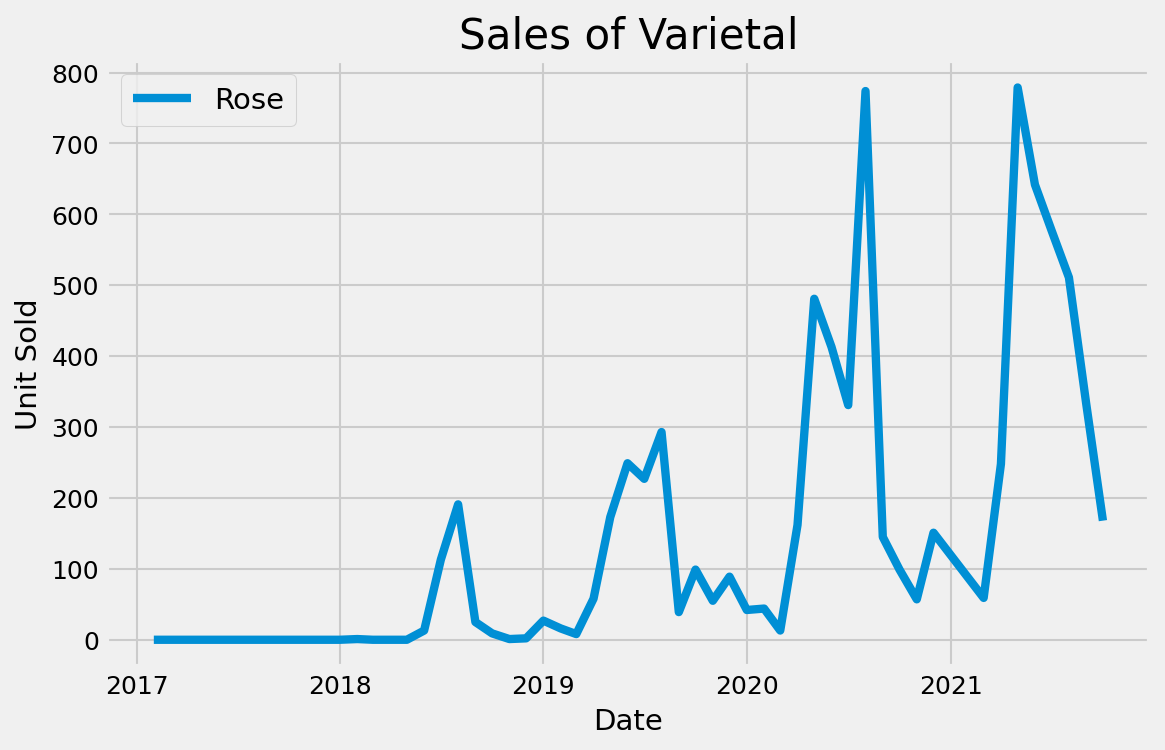

In [160]:
#df.plot(figsize=(18, 8))
#plt.show()

plt.figure(figsize=(8, 5))
plt.plot(df['Date'], df['9L Cases'],  label = 'Rose')

plt.xlabel('Date'); plt.ylabel('Unit Sold'); plt.title('Sales of Varietal')
plt.legend();

In [161]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['9L Cases'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.519440
p-value: 0.888167


In [162]:
df = df.rename(columns={'Date': 'ds', '9L Cases': 'y'})
df.head()

,ds,y
0,2017-02-01,0.0
1,2018-01-01,0.0
2,2018-02-01,1.0
3,2018-03-01,0.0
4,2018-04-01,0.0


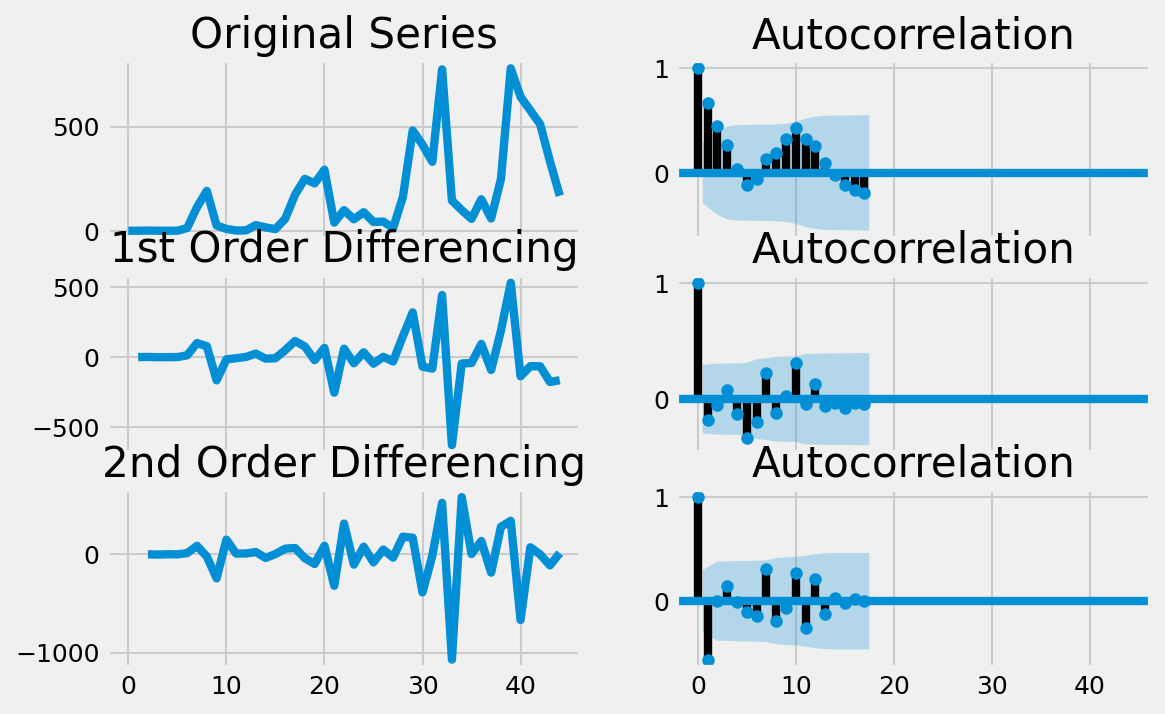

In [163]:
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':150})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.y); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(df.y, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.y.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.y.diff().diff().dropna(), ax=axes[2, 1])

## we need *2nd* order differencing


plt.show()

In [206]:
#prophet defaults to 80% interval.  
Varietal_model = Prophet(interval_width=0.80)
Varietal_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [207]:
Varietal_forecast = Varietal_model.make_future_dataframe(periods=24, freq='MS')
Varietal_forecast = Varietal_model.predict(Varietal_forecast)

In [208]:
#forecasted value
Varietal_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
64,2023-06-01,768.087737,671.314391,860.623420
65,2023-07-01,786.204048,694.827209,876.977551
66,2023-08-01,751.718869,650.385246,846.192441
67,2023-09-01,601.640341,501.490309,697.792530
68,2023-10-01,618.315411,527.334801,710.525939


In [209]:

from fbprophet.plot import plot_plotly, plot_components_plotly


plot_plotly(Varietal_model, Varietal_forecast)

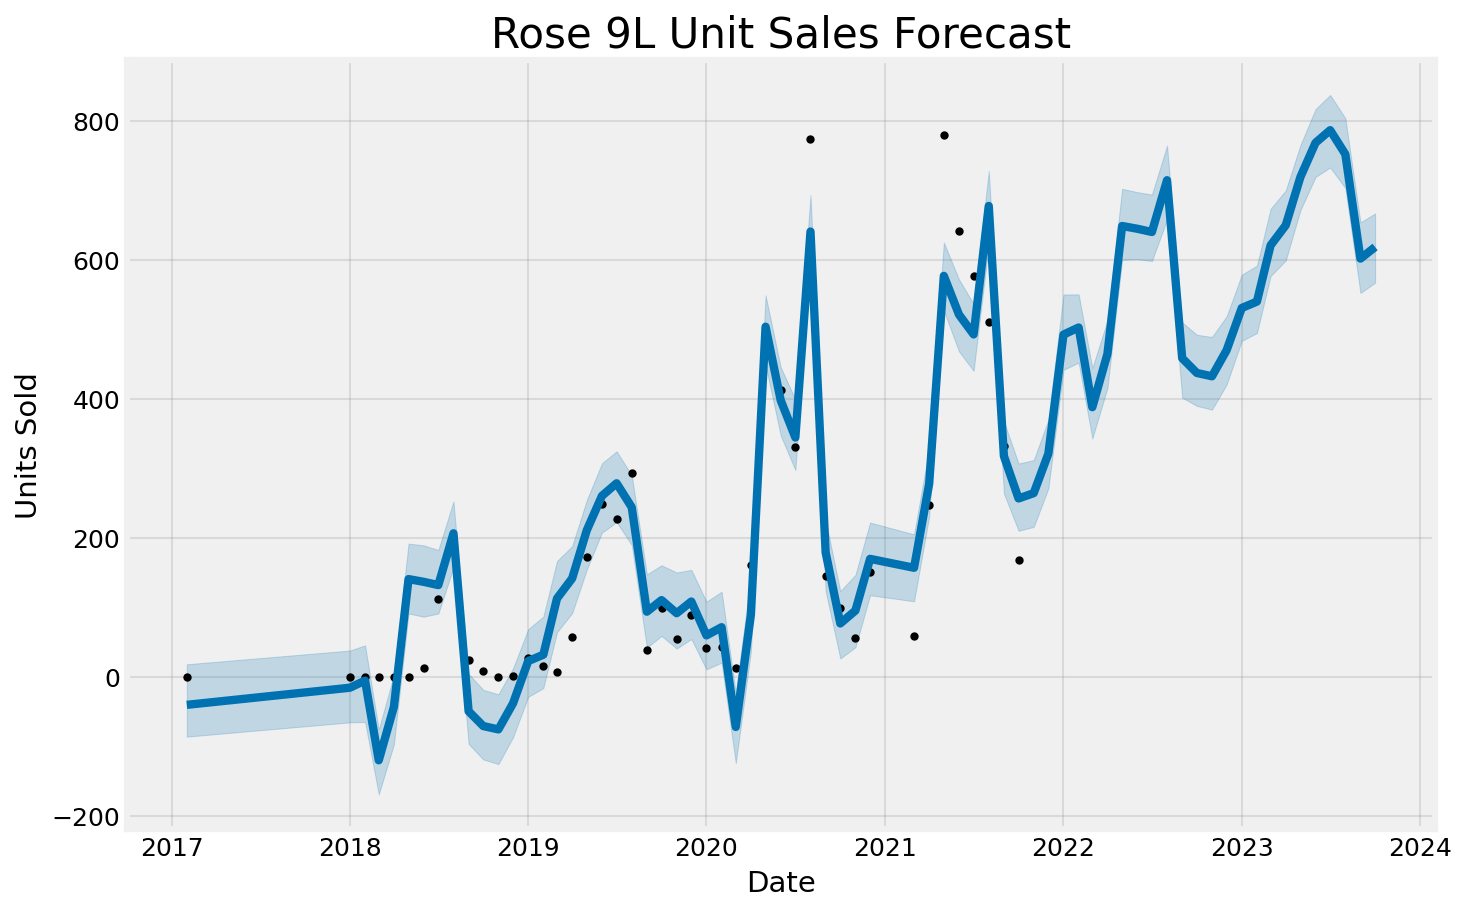

In [205]:
#plt.figure(figsize=(8, 5))

Varietal_model.plot(Varietal_forecast, xlabel = 'Date', ylabel = 'Units Sold')
plt.title('Rose 9L Unit Sales Forecast');

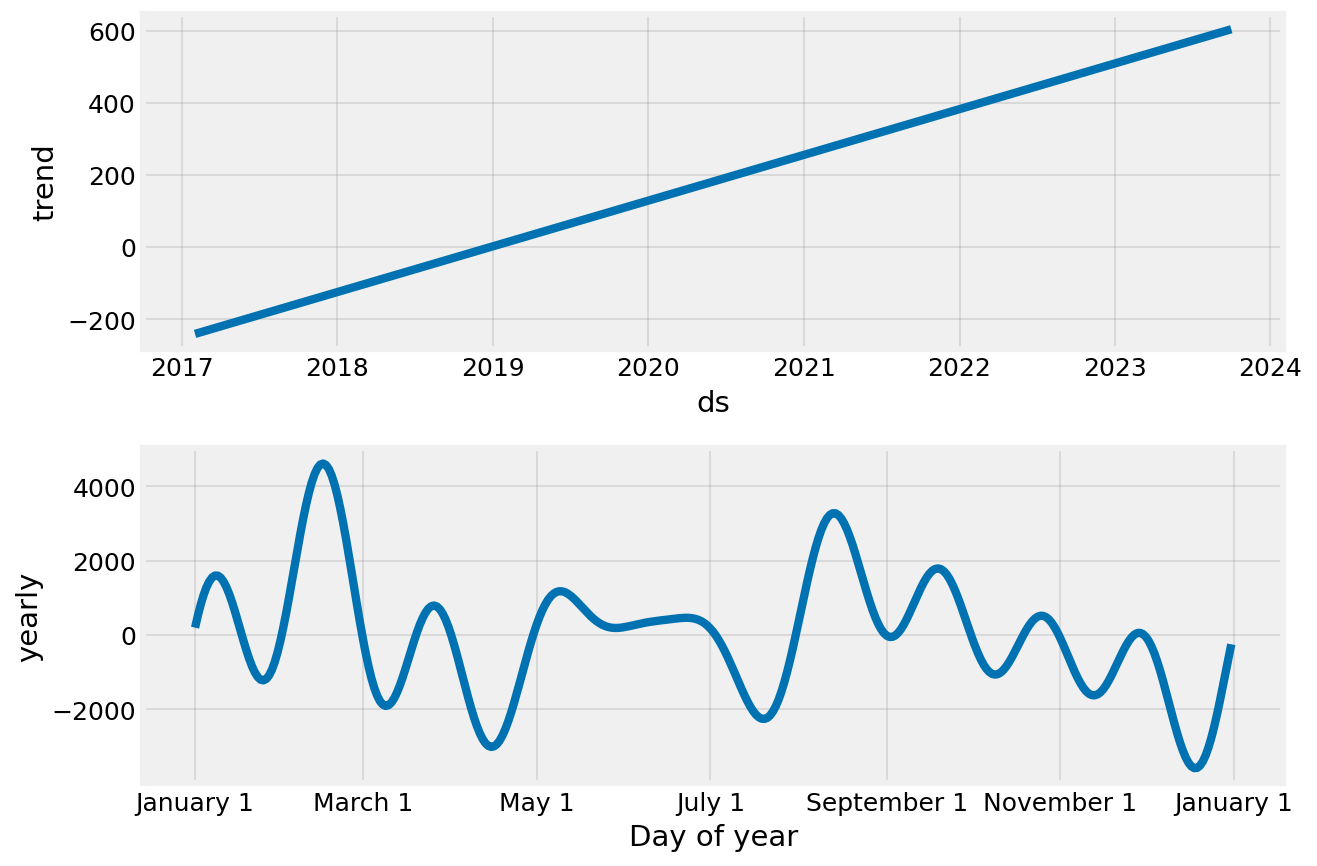

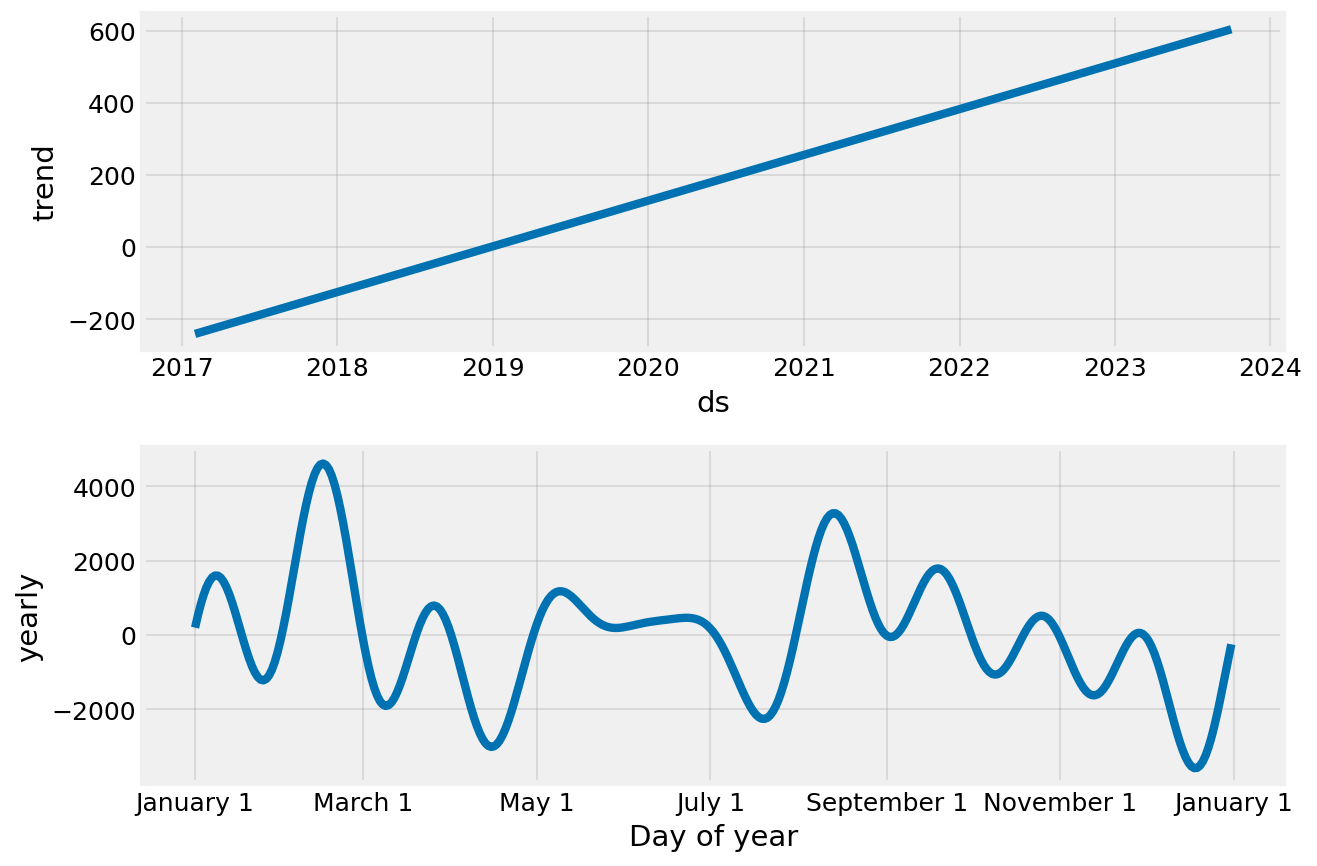

In [167]:
Varietal_model.plot_components(Varietal_forecast)